# Fully-Connected Neural Nets

In this notebook we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
  
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [29]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from deeplearning.classifiers.fc_net import *
from deeplearning.data_utils import get_CIFAR10_data
from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [30]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

deeplearning/datasets/cifar-10-batches-py/data_batch_1
deeplearning/datasets/cifar-10-batches-py/data_batch_2
deeplearning/datasets/cifar-10-batches-py/data_batch_3
deeplearning/datasets/cifar-10-batches-py/data_batch_4
deeplearning/datasets/cifar-10-batches-py/data_batch_5
deeplearning/datasets/cifar-10-batches-py/test_batch
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Affine layer: forward
Open the file `deeplearning/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [31]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [32]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)
# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  2.5765984411764716e-10
dw error:  4.30487383544444e-11
db error:  2.2482002755271025e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [33]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking. Note that the ReLU activation is not differentiable at 0, but typically we don't worry about this and simply assign either 0 or 1 as the derivative by convention.

In [34]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.275603579309874e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `deeplearning/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [35]:
from deeplearning.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  1.297791560761386e-10
dw error:  7.700401299162167e-11
db error:  8.0531387335597e-12


# Loss layers: Softmax and SVM
Here we provide two loss functions that we will use to train our deep neural networks. You should understand how they work by looking at the implementations in `deeplearnign/layers.py`.

You can make sure that the implementations are correct by running the following:

In [36]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.997524410673792
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302338026526943
dx error:  1.0050947784006226e-08


# Two-layer network

Open the file `deeplearning/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. Run the cell below to test your implementation.

In [37]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print ('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print ('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print ('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print ('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.21e-10
b1 relative error: 1.02e-08
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
Following a modular design, for this assignment we have split the logic for training models into a separate class from the models themselves.

Open the file `deeplearning/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [38]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
optim_config = {}
optim_config['learning_rate'] = 0.001
solver = Solver(model, data, optim_config=optim_config, lr_decay=0.9, num_epochs=10)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.302923
(Epoch 0 / 10) train acc: 0.139000; val_acc: 0.134000
(Iteration 11 / 4900) loss: 2.266739
(Iteration 21 / 4900) loss: 2.135247
(Iteration 31 / 4900) loss: 2.040783
(Iteration 41 / 4900) loss: 1.997397
(Iteration 51 / 4900) loss: 1.908751
(Iteration 61 / 4900) loss: 1.861658
(Iteration 71 / 4900) loss: 2.019971
(Iteration 81 / 4900) loss: 1.804237
(Iteration 91 / 4900) loss: 1.916447
(Iteration 101 / 4900) loss: 1.863785
(Iteration 111 / 4900) loss: 1.698928
(Iteration 121 / 4900) loss: 1.801930
(Iteration 131 / 4900) loss: 1.864173
(Iteration 141 / 4900) loss: 1.925834
(Iteration 151 / 4900) loss: 1.644489
(Iteration 161 / 4900) loss: 1.771972
(Iteration 171 / 4900) loss: 1.794034
(Iteration 181 / 4900) loss: 1.797230
(Iteration 191 / 4900) loss: 1.813382
(Iteration 201 / 4900) loss: 1.817059
(Iteration 211 / 4900) loss: 1.689675
(Iteration 221 / 4900) loss: 1.831240
(Iteration 231 / 4900) loss: 1.726141
(Iteration 241 / 4900) loss: 1.654928
(Iterat

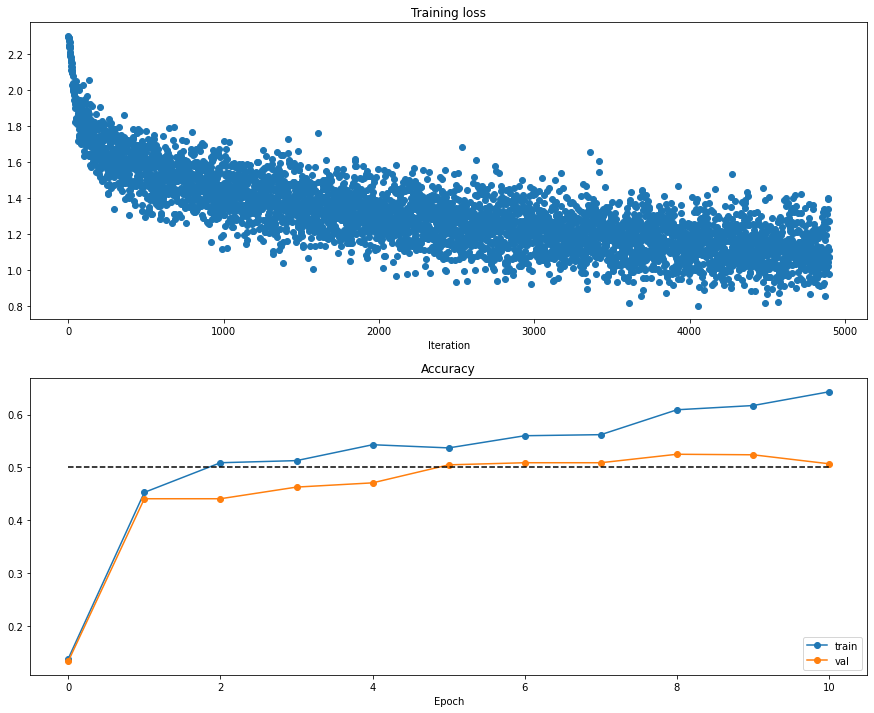

In [39]:
# Run this cell to visualize training loss and train / val accuracy, and save the log file of the
# experiment for submission.

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

solver.record_histories_as_npz('submission_logs/train_2layer_fc.npz')

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `deeplearning/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [40]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print ('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print ('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.307507449658023
W1 relative error: 2.55e-06
W2 relative error: 3.58e-05
W3 relative error: 1.55e-07
b1 relative error: 3.59e-08
b2 relative error: 1.34e-07
b3 relative error: 1.06e-10
Running check with reg =  3.14
Initial loss:  6.4578786684476945
W1 relative error: 1.66e-08
W2 relative error: 1.28e-08
W3 relative error: 2.30e-08
b1 relative error: 3.53e-08
b2 relative error: 4.25e-09
b3 relative error: 3.43e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.341250
(Epoch 0 / 20) train acc: 0.340000; val_acc: 0.145000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.152000
(Epoch 2 / 20) train acc: 0.380000; val_acc: 0.152000
(Epoch 3 / 20) train acc: 0.580000; val_acc: 0.138000
(Epoch 4 / 20) train acc: 0.340000; val_acc: 0.124000
(Epoch 5 / 20) train acc: 0.760000; val_acc: 0.189000
(Iteration 11 / 40) loss: 1.341355
(Epoch 6 / 20) train acc: 0.780000; val_acc: 0.199000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.165000
(Epoch 8 / 20) train acc: 0.880000; val_acc: 0.190000
(Epoch 9 / 20) train acc: 0.900000; val_acc: 0.188000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.188000
(Iteration 21 / 40) loss: 0.278567
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.193000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.189000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.199000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.190000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.200000
(Iteration 31 / 40) loss: 

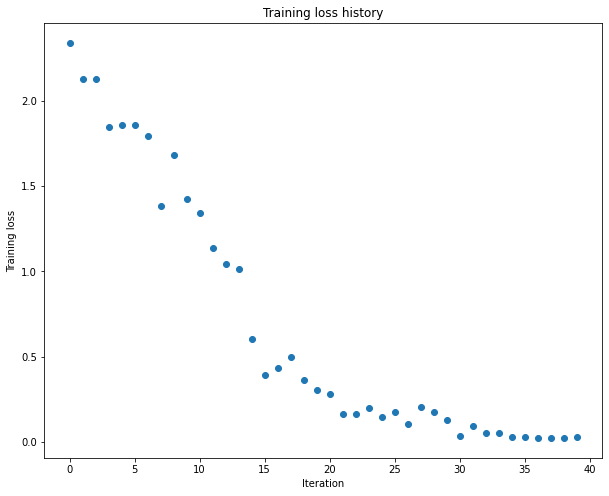

In [41]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

############################################################################
# TODO: Tune these parameters to get 100% train accuracy within 20 epochs. #
############################################################################ 
weight_scale = 1e-2 ## maybe can try a loop to scan these two hyper-parameters 
learning_rate = 1e-2## maybe can try a loop to scan these two hyper-parameters 
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

solver.record_histories_as_npz('submission_logs/overfit_3layer_fc.npz')

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 100.038546
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.082000
(Epoch 1 / 20) train acc: 0.220000; val_acc: 0.120000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.090000
(Epoch 3 / 20) train acc: 0.660000; val_acc: 0.123000
(Epoch 4 / 20) train acc: 0.680000; val_acc: 0.104000
(Epoch 5 / 20) train acc: 0.900000; val_acc: 0.119000
(Iteration 11 / 40) loss: 0.620134
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.102000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.107000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.105000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.108000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.108000
(Iteration 21 / 40) loss: 0.444763
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.107000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.107000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.107000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.107000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.107000
(Iteration 31 / 40) loss

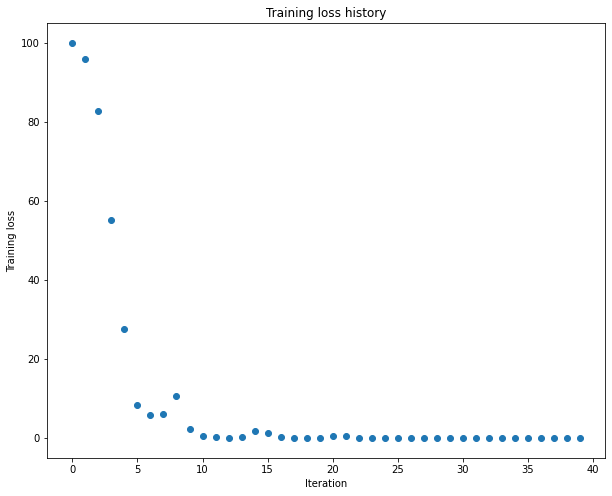

In [42]:
## TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

############################################################################
# TODO: Tune these parameters to get 100% train accuracy within 20 epochs. #
############################################################################
learning_rate = 1e-3
weight_scale = 1e-1
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

solver.record_histories_as_npz('submission_logs/overfit_5layer_fc.npz')

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
Sure, in this scenario, 5-layer-model is easier than 3-layer-model to achieve 100% training accuracy on 50 images


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `deeplearning/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [43]:
from deeplearning.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(0.5, 1.5, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-1, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
 [-0.504,      -0.45805263, -0.41210526, -0.36615789, -0.32021053],
 [-0.27426316, -0.22831579, -0.18236842, -0.13642105, -0.09047368],
 [-0.04452632,  0.00142105,  0.04736842,  0.09331579,  0.13926316],
 [ 0.18521053,  0.23115789,  0.27710526,  0.32305263,  0.369     ]])

expected_velocity = np.asarray([
 [1.04,       1.10684211, 1.17368421, 1.24052632, 1.30736842],
 [1.37421053, 1.44105263, 1.50789474, 1.57473684, 1.64157895],
 [1.70842105, 1.77526316, 1.84210526, 1.90894737, 1.97578947],
 [2.04263158, 2.10947368, 2.17631579, 2.24315789, 2.31      ]])

print ('next_w error: ', rel_error(next_w, expected_next_w))
print ('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  9.259267785377383e-07
velocity error:  2.1398003469119033e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge a bit faster.

running with  sgd
(Iteration 1 / 200) loss: 2.846063
(Epoch 0 / 5) train acc: 0.098000; val_acc: 0.110000
(Iteration 11 / 200) loss: 2.231074
(Iteration 21 / 200) loss: 2.151543
(Iteration 31 / 200) loss: 2.059140
(Epoch 1 / 5) train acc: 0.289000; val_acc: 0.243000
(Iteration 41 / 200) loss: 1.808746
(Iteration 51 / 200) loss: 1.879756
(Iteration 61 / 200) loss: 1.938387
(Iteration 71 / 200) loss: 1.782460
(Epoch 2 / 5) train acc: 0.378000; val_acc: 0.287000
(Iteration 81 / 200) loss: 1.783678
(Iteration 91 / 200) loss: 1.810538
(Iteration 101 / 200) loss: 1.748559
(Iteration 111 / 200) loss: 1.490481
(Epoch 3 / 5) train acc: 0.335000; val_acc: 0.264000
(Iteration 121 / 200) loss: 1.840961
(Iteration 131 / 200) loss: 1.794929
(Iteration 141 / 200) loss: 1.654608
(Iteration 151 / 200) loss: 1.665654
(Epoch 4 / 5) train acc: 0.403000; val_acc: 0.325000
(Iteration 161 / 200) loss: 1.687114
(Iteration 171 / 200) loss: 1.633910
(Iteration 181 / 200) loss: 1.750840
(Iteration 191 / 200) los

<ipython-input-44-3f26df74d708>:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 1)
<ipython-input-44-3f26df74d708>:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 2)
<ipython-input-44-3f26df74d708>:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created an

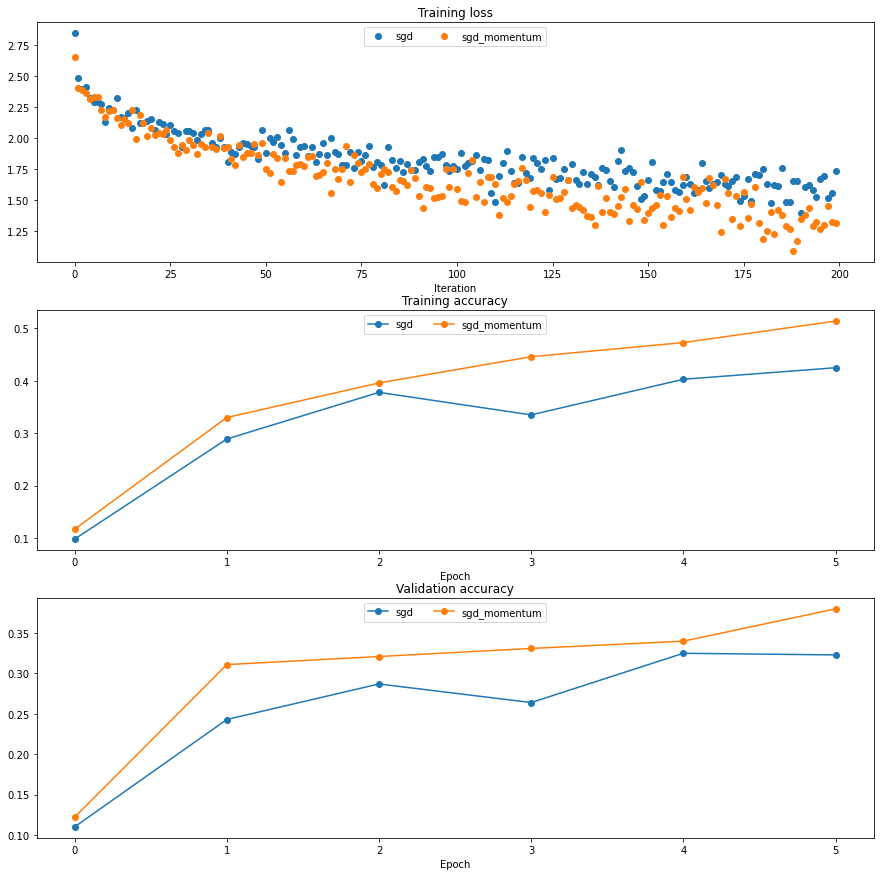

In [44]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print ('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    solver.record_histories_as_npz("submission_logs/optimizer_experiment_{}".format(update_rule))
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `deeplearning/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [45]:
# Test RMSProp implementation; you should see errors less than 1e-7.
from deeplearning.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.502645229894295e-08
cache error:  2.6477955807156126e-09


In [46]:
# Test Adam implementation; you should see errors around 1e-7 or less.
from deeplearning.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])
expected_t = 6

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('v error: ', rel_error(expected_v, config['v']))
print ('m error: ', rel_error(expected_m, config['m']))
print ('t error: ', rel_error(expected_t, config['t']))

next_w error:  1.139887467333134e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09
t error:  0.0


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules. As a sanity check, you should see that RMSProp and Adam typically obtain at least 45% training accuracy within 5 epochs.

running with  adam
(Iteration 1 / 200) loss: 2.994033
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.094000
(Iteration 11 / 200) loss: 1.972277
(Iteration 21 / 200) loss: 1.986379
(Iteration 31 / 200) loss: 1.973637
(Epoch 1 / 5) train acc: 0.369000; val_acc: 0.327000
(Iteration 41 / 200) loss: 1.778256
(Iteration 51 / 200) loss: 1.645467
(Iteration 61 / 200) loss: 1.625660
(Iteration 71 / 200) loss: 1.534360
(Epoch 2 / 5) train acc: 0.456000; val_acc: 0.313000
(Iteration 81 / 200) loss: 1.681062
(Iteration 91 / 200) loss: 1.523563
(Iteration 101 / 200) loss: 1.590558
(Iteration 111 / 200) loss: 1.468454
(Epoch 3 / 5) train acc: 0.479000; val_acc: 0.349000
(Iteration 121 / 200) loss: 1.443749
(Iteration 131 / 200) loss: 1.260118
(Iteration 141 / 200) loss: 1.302373
(Iteration 151 / 200) loss: 1.315320
(Epoch 4 / 5) train acc: 0.555000; val_acc: 0.357000
(Iteration 161 / 200) loss: 1.246658
(Iteration 171 / 200) loss: 1.152711
(Iteration 181 / 200) loss: 1.093154
(Iteration 191 / 200) lo

<ipython-input-47-bf70fdd886f5>:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 1)
<ipython-input-47-bf70fdd886f5>:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 1, 2)
<ipython-input-47-bf70fdd886f5>:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created an

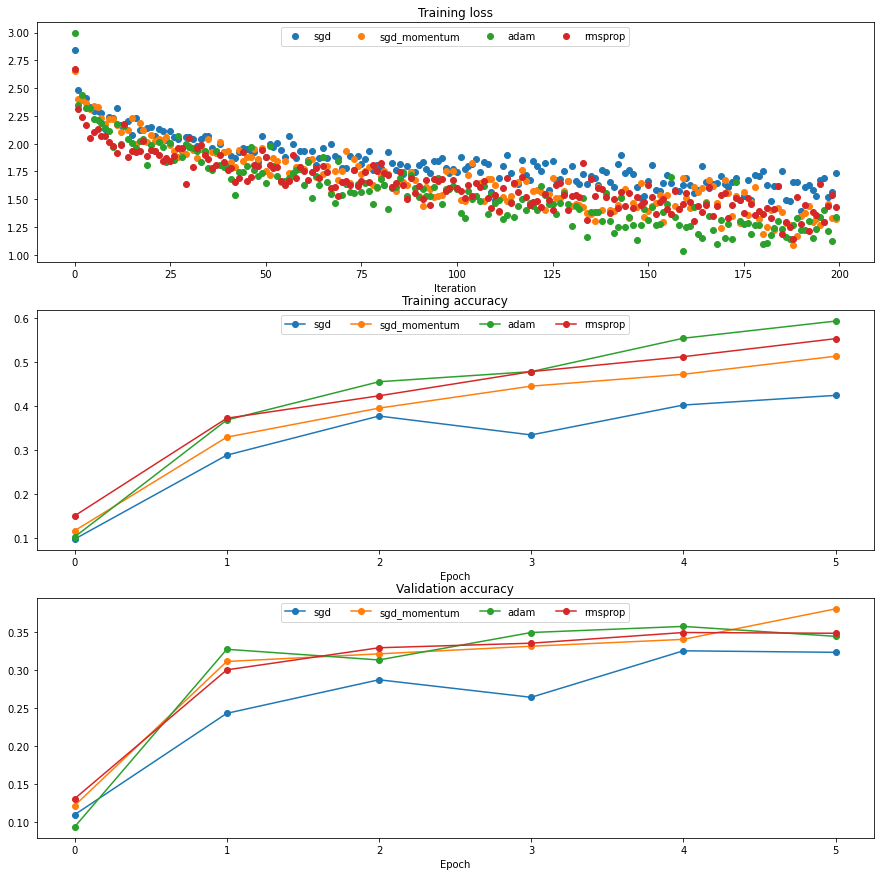

In [47]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print ('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    solver.record_histories_as_npz("submission_logs/optimizer_experiment_{}".format(update_rule))
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable and the solver used in the `best_solver` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [49]:
best_model = None
best_solver = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch normalization and dropout useful. Store your best model in the    #
# best_model variable and the solver used to train it in the best_solver       #
# variable.                                                                    #
################################################################################
best_val_acc = 0
## random setting rather than make hyper-parameters on grids
for i in range(20):
    weight_scale = 10**np.random.uniform(-3, -1)
    lr = 10**np.random.uniform(-4, -1)
    reg = 10**np.random.uniform(-3, 0)
    p = np.random.uniform(0, 0.3)
    
    model = FullyConnectedNet(
        hidden_dims=[200, 100, 50], weight_scale=weight_scale, reg=reg, use_batchnorm=True, dropout=p
    )

    solver = Solver(model, data,
                    num_epochs=10, batch_size=200,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                      'lr_decay': 0.99
                    },
                    verbose=False)
    solver.train()
    val_acc = solver.best_val_acc
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_model = model
        best_solver = solver
    # Print results
    print('val_acc = %f @ ws=%.2e, lr=%.2e, reg=%.2e, dropout=%.2f '%(val_acc, weight_scale, lr, reg, p))
    
print('------------------------------------DONE!!!------------------------------------')
print('Best validation accuracy achieved: %f'%best_val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

val_acc = 0.357000 @ ws=3.80e-03, lr=4.22e-03, reg=4.57e-02, dropout=0.06 
val_acc = 0.315000 @ ws=3.59e-03, lr=2.35e-03, reg=6.19e-01, dropout=0.02 
val_acc = 0.517000 @ ws=1.68e-02, lr=2.06e-04, reg=6.64e-02, dropout=0.05 
val_acc = 0.494000 @ ws=1.63e-03, lr=2.34e-04, reg=4.50e-02, dropout=0.17 
val_acc = 0.546000 @ ws=3.71e-02, lr=9.07e-04, reg=1.37e-03, dropout=0.03 
val_acc = 0.284000 @ ws=2.82e-02, lr=1.84e-02, reg=1.51e-02, dropout=0.26 
val_acc = 0.409000 @ ws=3.38e-02, lr=1.33e-02, reg=1.36e-03, dropout=0.00 
val_acc = 0.535000 @ ws=3.25e-03, lr=2.59e-04, reg=1.21e-03, dropout=0.20 
val_acc = 0.273000 @ ws=1.88e-03, lr=4.67e-03, reg=4.95e-01, dropout=0.23 
val_acc = 0.400000 @ ws=2.52e-02, lr=1.96e-03, reg=2.93e-02, dropout=0.23 
val_acc = 0.283000 @ ws=5.27e-02, lr=2.92e-02, reg=5.66e-03, dropout=0.29 
val_acc = 0.374000 @ ws=5.19e-03, lr=3.73e-03, reg=1.99e-02, dropout=0.18 
val_acc = 0.540000 @ ws=2.25e-03, lr=4.36e-04, reg=2.33e-03, dropout=0.08 
val_acc = 0.520000 @ ws=1

# Test your model
Run your best model on the validation and test sets and record the training logs of the best solver. You should achieve above 50% accuracy on the validation set.

In [50]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
val_acc = (y_val_pred == data['y_val']).mean()
test_acc = (y_test_pred == data['y_test']).mean()
print ('Validation set accuracy: ', val_acc)
print ('Test set accuracy: ', test_acc)
best_solver.record_histories_as_npz('submission_logs/best_fc_model.npz')

Validation set accuracy:  0.546
Test set accuracy:  0.538
